# Olist

## Nettoyage des données et EDA

la table customers contient deux colonnes similaires, `customer_id`  et `customer_unique_id` . En observant :

```sql
SELECT
count(DISTINCT customer_id) as count_customer_id
, count(DISTINCT customer_unique_id) as count_customer_unique_id
FROM `fai-data-portfolio.Olist.customers` LIMIT 1000


In [1]:
%%bigquery customers_count
SELECT
count(DISTINCT customer_id) as count_customer_id
, count(DISTINCT customer_unique_id) as count_customer_unique_id
FROM `fai-data-portfolio.Olist.customers`

Query is running:   0%|          |

Downloading:   0%|          |

In [2]:
customers_count

,count_customer_id,count_customer_unique_id
0,99441,96096


Ainsi, la vraie clé correspond à unique_id : 1 client, 1 unique_id. Il y a 3345 duplicates sur cette colonne, donc potentiellement, 3345 clients ayant placés des commandes multiples, c’est donc cette colonne qu’il conviendra de rapprocher dans les analyses de comportement client

Un certain nombre d'autres opérations d'amélioration des données a été effectué et enregistré dans les tables de staging. On a notamment vérifié les éléments dupliqués, les valeurs nulles.

# Analyse du comportement client

Les problématiques étudiées sont les suivantes :


*   Clients one-shot ou long-terme (plus d'une commande?)
*   Fréquence d'achat? (nombre d'achat moyen par an)
*   Top 10 clients selon le nombre de commandes payées ?



## Requête SQL globale

```sql
-- CTE (_order) : Agrège les données par client et année
WITH _order AS (
  SELECT
    customer_unique_id,
    EXTRACT(YEAR FROM order_purchase_timestamp) AS year,  -- Extrait l'année de la commande
    COUNT(order_id) AS total_order,  -- Totalise les commandes pour chaque client et année
    CASE
      WHEN COUNT(order_id) = 1 THEN "one_shot"  -- Classement des clients en fonction de leur fréquence d'achat
      ELSE "long_term"
    END AS cohort_number_order,
    MIN(order_purchase_timestamp) AS first_purchase_date,  -- Première commande
    MAX(order_purchase_timestamp) AS last_purchase_date  -- Dernière commande
  FROM `fai-data-portfolio.Olist.stg_orders`
  GROUP BY customer_unique_id, EXTRACT(YEAR FROM order_purchase_timestamp)
  ORDER BY customer_unique_id DESC
)

-- Requête principale : Ajoute des métriques basées sur des calculs analytiques
SELECT
  customer_unique_id,
  _order.year AS purchase_year,
  total_order,
  cohort_number_order,
  
  -- Nombre de commandes de l'année précédente pour le même client
  LAG(total_order) OVER (
    PARTITION BY customer_unique_id  -- Regroupe par client
    ORDER BY _order.year             -- Classe par année croissante pour chaque client
  ) AS previous_year_orders,
  
  -- Taux de croissance YoY : ((valeur actuelle - valeur précédente) / valeur précédente) * 100
  CASE
    WHEN LAG(total_order) OVER (PARTITION BY customer_unique_id ORDER BY _order.year) IS NOT NULL THEN
      (total_order - LAG(total_order) OVER (PARTITION BY customer_unique_id ORDER BY _order.year))
        * 100.0 / LAG(total_order) OVER (PARTITION BY customer_unique_id ORDER BY _order.year)
    ELSE NULL  -- Pas de taux calculable si pas de données de l'année précédente
  END AS growth_rate_yoy,
  
  first_purchase_date,
  last_purchase_date,
  
  -- Âge en jours : différence entre la première et la dernière commande
  DATE_DIFF(DATE(last_purchase_date), DATE(first_purchase_date), DAY) AS age_day

FROM _order
ORDER BY customer_unique_id, total_order DESC;


In [8]:
%%bigquery customer_behaviour_year
SELECT * FROM Olist.int_customer_behaviour_year

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
customer_behaviour_year.head()

,customer_unique_id,purchase_year,total_order,cohort_number_order,previous_year_orders,growth_rate_yoy,first_purchase_date,last_purchase_date,age_day
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,1,one_shot,<NA>,NaN,2018-05-10 10:56:27+00:00,2018-05-10 10:56:27+00:00,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,1,one_shot,<NA>,NaN,2018-05-07 11:11:27+00:00,2018-05-07 11:11:27+00:00,0
2,0000f46a3911fa3c0805444483337064,2017,1,one_shot,<NA>,NaN,2017-03-10 21:05:03+00:00,2017-03-10 21:05:03+00:00,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017,1,one_shot,<NA>,NaN,2017-10-12 20:29:41+00:00,2017-10-12 20:29:41+00:00,0
4,0004aac84e0df4da2b147fca70cf8255,2017,1,one_shot,<NA>,NaN,2017-11-14 19:45:42+00:00,2017-11-14 19:45:42+00:00,0


In [13]:
customer_behaviour_year.describe()

,purchase_year,total_order,previous_year_orders,growth_rate_yoy,age_day
count,95664.0,95664.0,674.0,674.000000,95664.0
mean,2017.544029,1.026583,1.149852,3.396802,1.025255
std,0.504172,0.178832,0.592003,40.385358,11.336448
min,2016.0,1.0,1.0,-80.000000,0.0
25%,2017.0,1.0,1.0,0.000000,0.0
50%,2018.0,1.0,1.0,0.000000,0.0
75%,2018.0,1.0,1.0,0.000000,0.0
max,2018.0,9.0,9.0,500.000000,313.0


Vérifions l'existence de clients ayant passés différentes commandes sur des années différentes :

In [26]:
customers_long_term = customer_behaviour_year[
                        (customer_behaviour_year['cohort_number_order']=="long_term") &
                         (customer_behaviour_year['growth_rate_yoy'].notna())]
customers_long_term.head()

,customer_unique_id,purchase_year,total_order,cohort_number_order,previous_year_orders,growth_rate_yoy,first_purchase_date,last_purchase_date,age_day
1091,02e9109b7e0a985108b43e573b6afb23,2018,2,long_term,1,100.0,2018-05-13 23:53:10+00:00,2018-05-14 11:04:55+00:00,1
3320,08c07c761592a71b85136aa4fe76a6f4,2018,2,long_term,1,100.0,2018-01-26 22:03:52+00:00,2018-04-06 15:28:48+00:00,70
7093,12d8b5ed661190a3a08183644dfc504d,2018,3,long_term,1,200.0,2018-02-26 22:45:04+00:00,2018-05-02 11:58:28+00:00,65
10312,1b6c7548a2a1f9037c1fd3ddfed95f33,2018,2,long_term,5,-60.0,2018-01-25 12:47:39+00:00,2018-02-14 13:22:12+00:00,20
10320,1b6e96ed99cb8d135efe220d761bbd67,2018,2,long_term,1,100.0,2018-01-14 17:25:31+00:00,2018-08-15 19:50:32+00:00,213


In [27]:
customers_long_term.count()

,0
customer_unique_id,54
purchase_year,54
total_order,54
cohort_number_order,54
previous_year_orders,54
growth_rate_yoy,54
first_purchase_date,54
last_purchase_date,54
age_day,54


Comparons avec le nombre global de clients enregistrés comme long-terme, c'est à dire avec plus d'une commande :

In [3]:
%%bigquery customer_cohort
-- CTE (intermediary_table) : Calcule les totaux et pourcentages par catégorie de cohorte
WITH intermediary_table AS (
  SELECT
    cohort_number_order AS cohort_category,  -- Catégorie de cohorte (one_shot ou long_term)
    COUNT(DISTINCT customer_unique_id) AS total_customer,  -- Nombre total de clients uniques par catégorie
    COUNT(DISTINCT customer_unique_id) * 100 / SUM(COUNT(*)) OVER() AS percentage_total  -- Pourcentage du total des clients
  FROM `fai-data-portfolio.Olist.int_customer_behaviour_year`
  GROUP BY cohort_number_order
)

-- Requête principale : Formate les résultats finaux
SELECT
  cohort_category,  -- Catégorie de cohorte
  total_customer,  -- Nombre total de clients uniques
  ROUND(percentage_total, 2) AS percentage_total  -- Pourcentage arrondi à deux décimales
FROM intermediary_table;


Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
customer_cohort

,cohort_category,total_customer,percentage_total
0,one_shot,92760,96.96
1,long_term,2318,2.42


Il y a donc 2318 clients ayant fait plus d'une commande, mais seulement 54 avec des commandes sur des années différentes ! Ceci laisse peut de place à une analyse poussée sur le comportement au cours du temps des clients.

Analysons rapidement la cohort long-terme plus précisement :


In [47]:
%%bigquery analysis_longterm_cohort
-- intermediary_table : classifie la fréquence d'achat et calcule le nombre moyen de commande par an
WITH intermediary_table AS (SELECT *
, CASE
    WHEN total_order = 2 OR total_order = 3 THEN "occasional(2-3)"
    WHEN total_order >3 THEN "frequent(>3)"
  END AS purchase_frequency
, CAST(ROUND(SAFE_DIVIDE(total_order,(age_day/365)),0) AS int64) as avg_order_per_year
 FROM `fai-data-portfolio.Olist.int_customer_behaviour`
 where cohort_category = "long_term"
)

-- Table finale donnant les KPIs par catégorie
SELECT
purchase_frequency
, SUM(total_order) as total_order
, ROUND(AVG(total_order),1) as avg_total_order
, MAX(total_order) as max_orders
, ROUND(AVG(avg_order_per_year),1) as avg_order_per_year
, MAX(age_day) as max_tenure
, ROUND(AVG(age_day),0) as avg_tenure
FROM intermediary_table
GROUP BY purchase_frequency


Query is running:   0%|          |

Downloading:   0%|          |

In [48]:
analysis_longterm_cohort.head()

,purchase_frequency,total_order,avg_total_order,max_orders,avg_order_per_year,max_tenure,avg_tenure
0,occasional(2-3),4727,2.1,3,66.4,313,41.0
1,frequent(>3),237,4.9,16,97.9,282,96.0


## Top Client


Afin d'obtenir le top 10 clients d'après le nombre de commandes payées, nous utilisons les tables `orders` et `orders_items` nettoyées et améliorées.

```sql
-- CTE (int_table) : Préparation des données agrégées par client
WITH int_table AS (
  SELECT
    customer_unique_id,  -- Identifiant unique du client
    COUNT(DISTINCT order_id) AS total_order,  -- Nombre total de commandes par client
    CAST(AVG(total_items) AS int64) AS avg_items_per_order,  -- Moyenne arrondie du nombre d'articles par commande
    SUM(total_price) AS total_price,  -- Montant total dépensé par client
    SAFE_DIVIDE(
      SUM(SUM(total_price)) OVER (),  -- Total global des montants (fenêtre sur toutes les lignes)
      SUM(COUNT(DISTINCT order_id)) OVER ()  -- Total global des commandes distinctes (fenêtre sur toutes les lignes)
    ) AS global_avg_basket_value  -- Valeur moyenne globale du panier (toutes commandes confondues)
  FROM `fai-data-portfolio.Olist.int_orders_value`
  WHERE order_status <> "canceled" AND order_status <> "unavailable"  -- Filtre les commandes annulées ou indisponibles
  GROUP BY customer_unique_id  -- Regroupe par client
)

-- Requête principale : Ajout des ratios et sélection des top clients
SELECT
  customer_unique_id,  -- Identifiant unique du client
  int_table.total_order AS total_order,  -- Nombre total de commandes
  int_table.avg_items_per_order AS avg_items_per_order,  -- Moyenne d'articles par commande
  int_table.total_price AS total_price,  -- Montant total dépensé
  ROUND(SAFE_DIVIDE(total_price, int_table.global_avg_basket_value), 1) AS ratio_to_avg_basket_value  -- Ratio du total dépensé par rapport au panier moyen global
FROM int_table
ORDER BY total_price DESC  -- Trie par montant total dépensé (décroissant)
LIMIT 10;  -- Limite à 10 résultats


In [51]:
%%bigquery top_10_clients

SELECT * FROM Olist.top_10_clients
ORDER BY total_price DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [52]:
top_10_clients

,customer_unique_id,total_order,avg_items_per_order,total_price,ratio_to_avg_basket_value
0,0a0a92112bd4c708ca5fde585afaa872,1,8,13440.0,97.8
1,da122df9eeddfedc1dc1f5349a1a690c,2,1,7388.0,53.8
2,763c8b1c9c68a0229c42c9fc6f662b93,1,4,7160.0,52.1
3,dc4802a71eae9be1dd28f5d788ceb526,1,1,6735.0,49.0
4,459bef486812aa25204be022145caa62,1,1,6729.0,49.0
5,ff4159b92c40ebe40454e3e6a7c35ed6,1,1,6499.0,47.3
6,4007669dec559734d6f53e029e360987,1,6,5934.6,43.2
7,eebb5dda148d3893cdaf5b5ca3040ccb,1,1,4690.0,34.1
8,48e1ac109decbb87765a3eade6854098,1,1,4590.0,33.4
9,a229eba70ec1c2abef51f04987deb7a5,1,2,4400.0,32.0


The last column give the ration of the customer total paid on the average basket value. Which means that the first customer's revenue represents 98x the average basket value

## Orders analysis

*   Look at category seasonality in orders?
*   Calculate AOV (Average Order Value)?
*  Avg number of products in an order?



```sql
SELECT
COUNT(DISTINCT order_id) as count_orders
, ROUND(SUM(price),1) as total_price_value
, ROUND(SUM(price) / COUNT(DISTINCT order_id),1) as avg_order_value
, ROUND(COUNT(order_item_id)/COUNT(DISTINCT order_id),2) as avg_product_per_order
  FROM `fai-data-portfolio.Olist.stg_order_items`


In [61]:
%%bigquery analysis_orders
SELECT* FROM Olist.KPIs_orders

Query is running:   0%|          |

Downloading:   0%|          |

In [62]:
analysis_orders

,count_orders,total_price_value,avg_order_value,avg_product_per_order
0,98199,13494400.7,137.4,1.14


## Saisonnalité des commandes par catégorie


In [57]:
%%bigquery seasonality_category
SELECT * FROM Olist.seasonality_category
ORDER BY product_category

Query is running:   0%|          |

Downloading:   0%|          |

In [58]:
seasonality_category

,product_category,purchase_month,count_order
0,agro_industria_e_comercio,1,17
1,agro_industria_e_comercio,2,28
2,agro_industria_e_comercio,3,27
3,agro_industria_e_comercio,4,12
4,agro_industria_e_comercio,5,12
...,...,...,...
801,utilidades_domesticas,8,806
802,utilidades_domesticas,9,223
803,utilidades_domesticas,10,200
804,utilidades_domesticas,11,351


In [59]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_categories(dataframe, num_categories):
    """
    Affiche un graphique à barres empilées des catégories avec le plus de commandes totales annuelles.

    Args:
        dataframe (pd.DataFrame): DataFrame contenant les colonnes 'product_category', 'purchase_month', 'count_order'.
        num_categories (int): Nombre de catégories les plus populaires à afficher.
    """

    # Calculer le total annuel par catégorie
    top_categories = (
        dataframe.groupby('product_category')['count_order']
        .sum()
        .nlargest(num_categories)
        .index
    )

    # Filtrer le DataFrame pour les catégories sélectionnées
    filtered_df = dataframe[dataframe['product_category'].isin(top_categories)]

    # Préparer les données pour le graphique
    pivot_df = filtered_df.pivot(index='purchase_month', columns='product_category', values='count_order').fillna(0)

    # Créer le graphique
    pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

    # Personnalisation du graphique
    plt.title(f'Top {num_categories} catégories par nombre de commandes mensuelles', fontsize=16)
    plt.xlabel('Mois', fontsize=14)
    plt.ylabel('Nombre de commandes', fontsize=14)
    plt.legend(title='Catégories de produits', fontsize=12)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()


    plt.show()

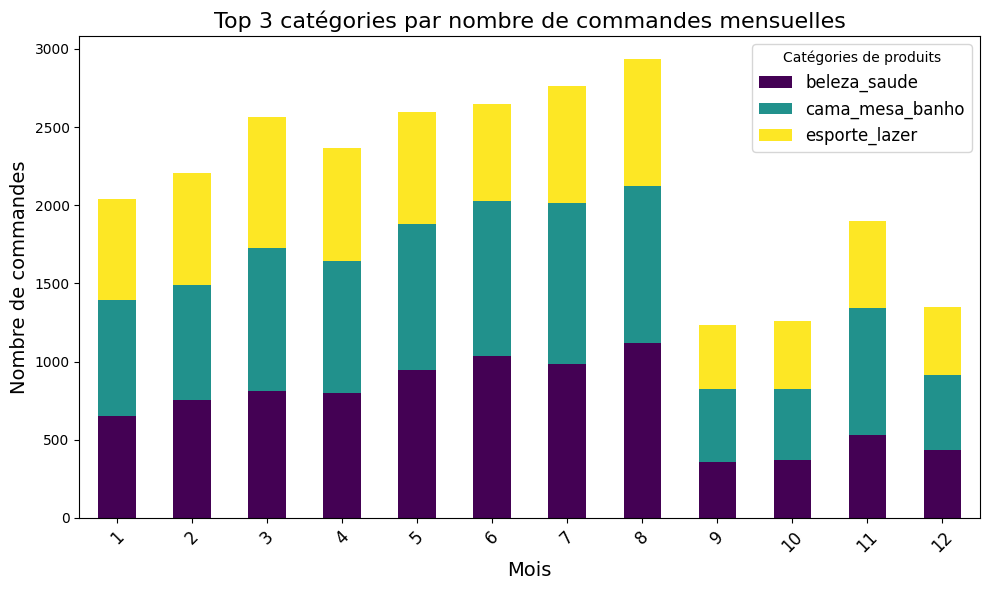

In [60]:
# Appel de la fonction
plot_top_categories(seasonality_category, num_categories=3)


En considérant les 3 catégories les plus représentées, nous voyons une saisonnalité claire, avec une forte diminution des ventes à partir de Septembre (rentrée scolaire),avec une légère augmentation sur Novembre (black Friday) et Décembre (période des fêtes).

NB : on peut suspecter ici qu'il s'agit d'un échantillon de données fabriqué vu la répartition des données qui semble distribuées trop proportionnellement (**effet rateau**).